# 从特征筛选到分类建模全流程实践及作图

#### 导入包

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.stats import ttest_ind, levene
from sklearn.linear_model import LassoCV
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, classification_report

#### 导入数据

In [2]:
xlsx_a = 'data/featureTable/aa.xlsx'
xlsx_b = 'data/featureTable/bb.xlsx'
data_a = pd.read_excel(xlsx_a)
data_b = pd.read_excel(xlsx_b)
print(data_a.shape,data_b.shape)

(212, 30) (357, 30)


#### 数据预处理

In [3]:
rows_a,cols_a = data_a.shape
rows_b,cols_b = data_b.shape
labels_a = np.zeros(rows_a)
labels_b = np.ones(rows_b)
data_a.insert(0, 'label', labels_a)
data_b.insert(0, 'label', labels_b)
data = pd.concat([data_a,data_b])

#### 数据集划分

In [4]:
data_train, data_test = train_test_split(data,test_size=0.3,random_state = 15)
data_train_a = data_train[:][data_train['label'] == 0]
data_train_b = data_train[:][data_train['label'] == 1]
data_test_a = data_test[:][data_test['label'] == 0]
data_test_b = data_test[:][data_test['label'] == 1]
print(data_train_a.shape)
print(data_train_b.shape)
print(data_test_a.shape)
print(data_test_b.shape)

(150, 31)
(248, 31)
(62, 31)
(109, 31)


#### T检验特征筛选

In [5]:
index = []
for colName in data.columns[:]:
    if levene(data_train_a[colName], data_train_b[colName])[1] > 0.05: 
        if ttest_ind(data_train_a[colName], data_train_b[colName])[1] < 0.05: 
            index.append(colName)
    else: 
        if ttest_ind(data_train_a[colName], data_train_b[colName],equal_var=False)[1] < 0.05: 
            index.append(colName)
print(len(index))
print(index)

26
['label', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'M', 'N', 'P', 'Q', 'R', 'U', 'V', 'W', 'X', 'Y', 'Z', 'AA', 'AB', 'AC', 'AD']


C:\Users\99563\AppData\Local\Programs\Python\Python37\lib\site-packages\scipy\stats\morestats.py:2603: RuntimeWarning: invalid value encountered in double_scalars
  W = numer / denom


#### T检验后训练集数据整理

In [6]:
data_train_a = data_train_a[index]
data_train_b = data_train_b[index]
data_train = pd.concat([data_train_a, data_train_b])
data_train = shuffle(data_train)
data_train.index = range(len(data_train))
X_train = data_train[data_train.columns[1:]]
# 注意下面两行在训练集与测试集上的区别
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_train = pd.DataFrame(X_train)
X_train.columns = index[1:]
y_train = data_train['label']

#### T检验后测试集数据整理

In [7]:
data_test_a = data_test_a[index]
data_test_b = data_test_b[index]
data_test = pd.concat([data_test_a, data_test_b])
data_test = shuffle(data_test)
data_test.index = range(len(data_test))
X_test = data_test[data_test.columns[1:]]
X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test)
X_test.columns = index[1:]
y_test = data_test['label']

#### LASSO特征筛选

In [8]:
alphas = np.logspace(-4,1,50)
model_lassoCV = LassoCV(alphas = alphas, max_iter = 100000).fit(X_train,y_train)
coef = pd.Series(model_lassoCV.coef_, index = X_train.columns)
print(model_lassoCV.alpha_)
print('%s %d'%('Lasso picked',sum(coef != 0)))
index = coef[coef != 0].index
X_train_raw = X_train
X_train = X_train[index]
X_test = X_test[index]

0.0006551285568595509
Lasso picked 19


#### 特征权重图

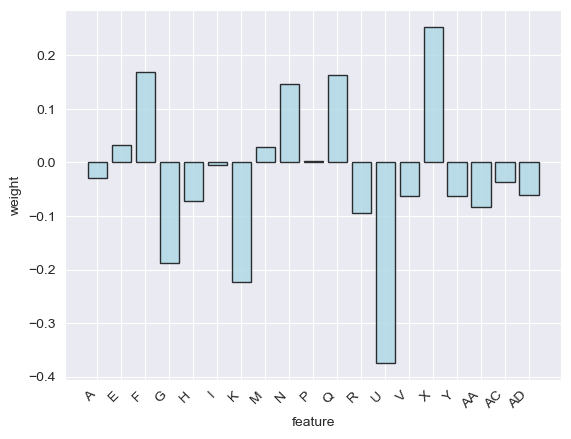

In [12]:
plt.figure()
x_values = np.arange(len(index))
y_values = coef[coef != 0]
plt.bar(x_values, y_values        #横向bar使用：barh
        , color = 'lightblue'     #设置bar的颜色
        , edgecolor = 'black'     #设置bar边框颜色
        , alpha = 0.8             #设置不透明度
       )
plt.xticks(x_values,index
           , rotation='45'        #旋转xticks
           , ha = 'right'         #xticks的水平对齐方式
           ,va = 'top'            #xticks的垂直对齐方式
          )
plt.xlabel("feature")             #横轴名称
plt.ylabel("weight")              #纵轴名称
plt.show()

#### 特征相关性热度图

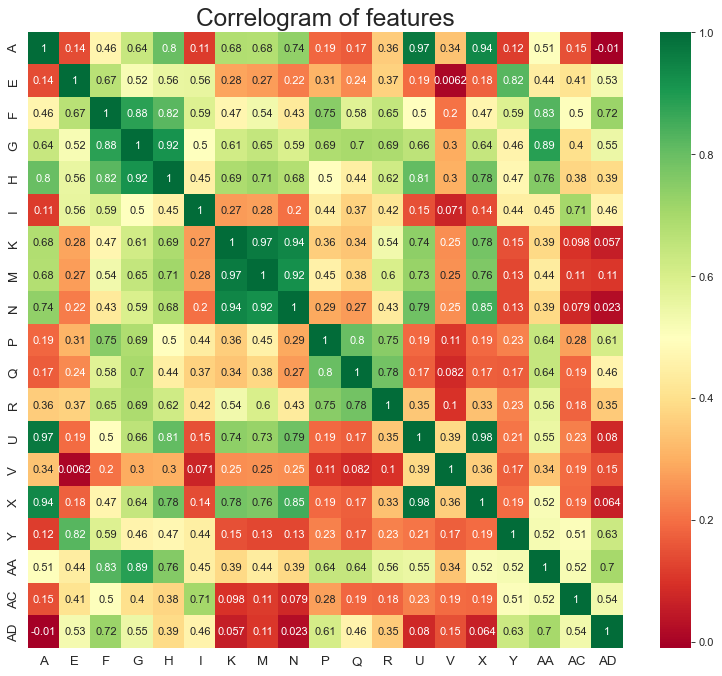

In [18]:
plt.figure(figsize=(12,10), dpi= 80)
sns.heatmap(X_train.corr()                           #计算特征间的相关性
            , xticklabels=X_train.corr().columns
            , yticklabels=X_train.corr().columns
            , cmap='RdYlGn'
            , center=0.5
            , annot=True)
plt.title('Correlogram of features', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

#### LASSO模型中Lambda选值图

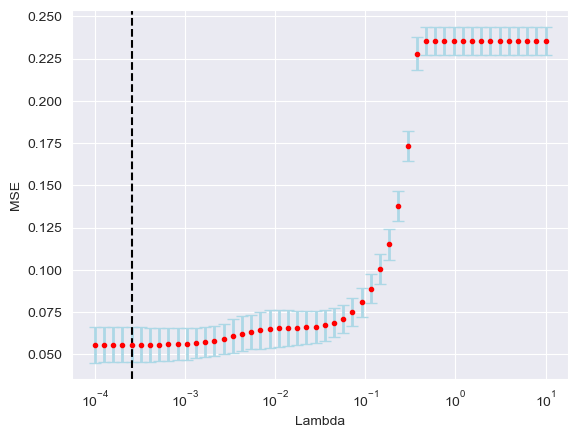

In [21]:
MSEs = model_lassoCV.mse_path_
"""
MSEs_mean, MSEs_std = [], []
for i in range(len(MSEs)):
    MSEs_mean.append(MSEs[i].mean())
    MSEs_std.append(MSEs[i].std())
"""
MSEs_mean = np.apply_along_axis(np.mean,1,MSEs)
MSEs_std = np.apply_along_axis(np.std,1,MSEs)

plt.figure()
plt.errorbar(model_lassoCV.alphas_,MSEs_mean    #x, y数据，一一对应
             , yerr=MSEs_std                    #y误差范围
             , fmt="o"                          #数据点标记
             , ms=3                             #数据点大小
             , mfc="r"                          #数据点颜色
             , mec="r"                          #数据点边缘颜色
             , ecolor="lightblue"               #误差棒颜色
             , elinewidth=2                     #误差棒线宽
             , capsize=4                        #误差棒边界线长度
             , capthick=1)                      #误差棒边界线厚度
plt.semilogx()
plt.axvline(model_lassoCV.alpha_,color = 'black',ls="--")
plt.xlabel('Lambda')
plt.ylabel('MSE')
plt.show()

#### 特征系数随Lambda变化曲线

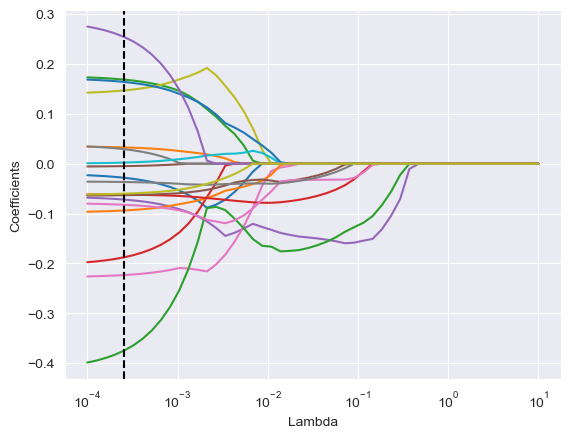

In [22]:
coefs = model_lassoCV.path(X_train_raw,y_train,alphas = alphas, max_iter = 100000)[1].T
plt.figure()
plt.semilogx(model_lassoCV.alphas_,coefs, '-')
plt.axvline(model_lassoCV.alpha_,color = 'black',ls="--")
plt.xlabel('Lambda')
plt.ylabel('Coefficients')
plt.show()

#### 随机森林分类器

In [9]:
model_rf = RandomForestClassifier(n_estimators = 200
                                  , criterion = 'entropy'
                                  , random_state = 20
                                  , class_weight = 'balanced'
                                 )
model_rf.fit(X_train,y_train)
print(model_rf.score(X_test,y_test))

0.9532163742690059


#### ROC曲线

In [ ]:
y_test_probs = model_rf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_test_probs[:,1], pos_label = 1)
plt.figure()
plt.plot(fpr, tpr, marker = 'o')
plt.xlabel("1 - Specificity")
plt.ylabel("Sensitivity")
plt.show()

auc_score = roc_auc_score(y_test,model_rf.predict(X_test))
print(auc_score)

#### 精确度（Precision），敏感度（Sensitivity），特异度（Specificity）等输出
##### 将“1”类作为“阳性”时，“0”类的recall即为Specificity

In [34]:
y_test_pred = model_rf.predict(X_test)
print(classification_report(y_test, y_test_pred))

0      0.0
1      0.0
2      0.0
3      0.0
4      1.0
      ... 
166    1.0
167    1.0
168    1.0
169    0.0
170    1.0
Name: label, Length: 171, dtype: float64
[0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1.
 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1.
 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0.
 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0.
 1. 0. 1.]
              precision    recall  f1-score   support

         0.0       0.98      0.89      0.93        62
         1.0       0.94      0.99      0.96       109

    accuracy                           0.95       171
   macro avg       0.96      0.94      0.95       171
weighted avg       0.95      0.95      0.95 

In [35]:
print('前方没有终点，奋斗永不停息。\n——《和自己赛跑的人》李宗盛')

前方没有终点，奋斗永不停息。
——《和自己赛跑的人》李宗盛
